In [1]:
%cd ..
import numpy as np
from matplotlib import pyplot as plt
import pycircstat as pcs
from clwe.clwe import *

/home/ubuntu/clwe_watermark


In [33]:
def get_cov_score(samples):
    sample_cov = ((samples.T @ samples) / samples.shape[0]) / (2*np.pi)
    eigenvals, _ = np.linalg.eig(sample_cov)
    return max(abs(eigenvals - 1 / (2*np.pi)))

def get_eval_attack_scores(secret_dim, sample_dims, gamma,  beta, iters=100):
    # thresh = gamma * gamma * np.exp(-np.pi * (beta * beta + gamma * gamma)) / 4
    max_sample_dim = max(sample_dims)
    secret_dir = sample_unit_vector(secret_dim, 42)

    norm_scores, clwe_scores = [], []
    # tpr, fpr = 0, 0
    for _ in range(iters):
        raw_samples = get_random_samples((max_sample_dim, secret_dim), var=1)
        clwe_samples = project_to_clwe(raw_samples, secret_dir, gamma, beta)
        norm_scores.append([ get_cov_score(raw_samples[:d]) for d in sample_dims ])
        clwe_scores.append([ get_cov_score(clwe_samples[:d]) for d in sample_dims ])

    return norm_scores, clwe_scores

norm_scores, clwe_scores = get_eval_attack_scores(32, (5000,), 1, 1e-3, iters=1000)
norm_scores = np.array(norm_scores).flatten()
clwe_scores = np.array(clwe_scores).flatten()

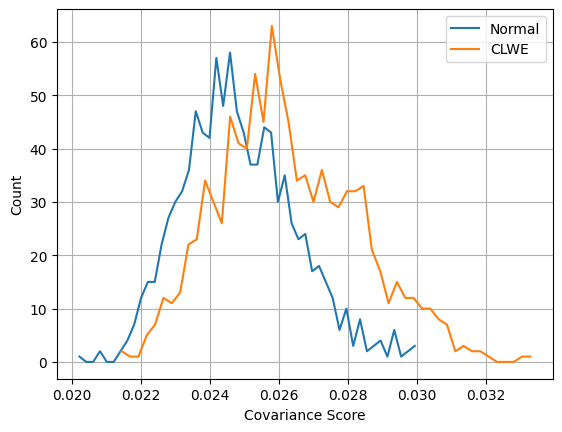

In [34]:
def plot_hist(scores, label):
    counts, bin_edges = np.histogram(scores, bins=50, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, counts, label=label)
plot_hist(norm_scores, "Normal")
plot_hist(clwe_scores, "CLWE")
plt.legend()
plt.xlabel("Covariance Score")
plt.ylabel("Count")
plt.grid(True)

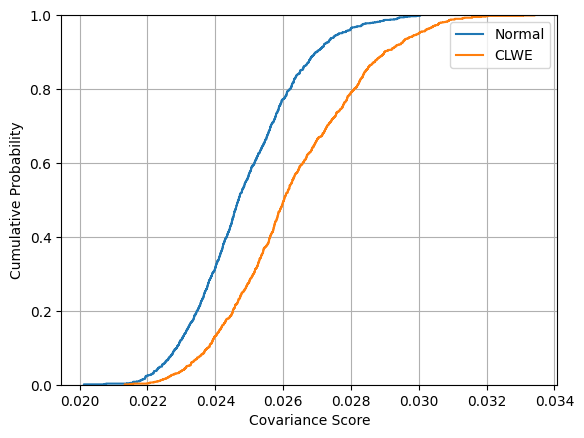

In [35]:
plt.ecdf(norm_scores, label="Normal")
plt.ecdf(clwe_scores, label="CLWE")
plt.legend()
plt.xlabel("Covariance Score")
plt.ylabel("Cumulative Probability")
plt.grid(True)

(1000,) (1000,)


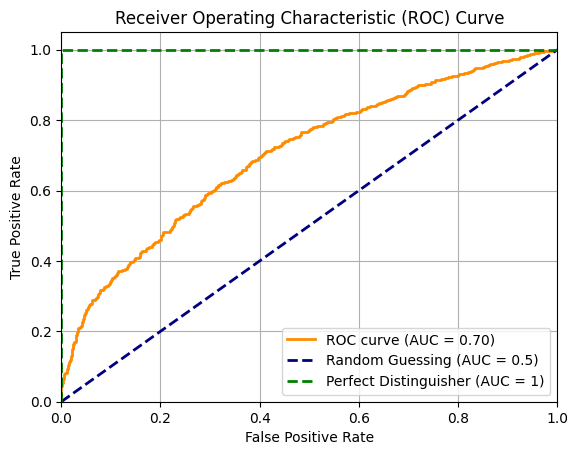

In [36]:
from sklearn.metrics import roc_curve, auc

def plot_roc(tvals, fvals):
    fpr, tpr, thresholds = roc_curve([0] * len(tvals) + [1] * len(fvals), np.concatenate((tvals, fvals)))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guessing (AUC = 0.5)")
    plt.plot([0, 0, 1], [0, 1, 1], color='green', lw=2, linestyle='--', label="Perfect Distinguisher (AUC = 1)")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

print(norm_scores.shape, clwe_scores.shape)
plot_roc(norm_scores, clwe_scores)

In [37]:
def calc_threshold(gamma, beta):
    return gamma * gamma * np.exp(-np.pi * (beta * beta + gamma * gamma))/4

def tcount(vals, thresh):
    return np.sum(np.array(vals) > thresh)

def theory_accuracy(gamma, beta, clwe_scores, norm_scores):
    thresh = calc_threshold(gamma, beta)
    tpr = tcount(clwe_scores, thresh) / len(clwe_scores)
    fpr = tcount(norm_scores, thresh) / len(norm_scores)
    return (1 + tpr - fpr) / 2

tpr = tcount(clwe_scores, calc_threshold(1, 1e-3)) / len(clwe_scores)
fpr = tcount(norm_scores, calc_threshold(1, 1e-3)) / len(norm_scores)
print("TPR:", tpr, "FPR:", fpr, "thresh", calc_threshold(1, 1e-3), "BA", theory_accuracy(1, 1e-3, clwe_scores, norm_scores))

TPR: 1.0 FPR: 1.0 thresh 0.010803445625864345 BA 0.5


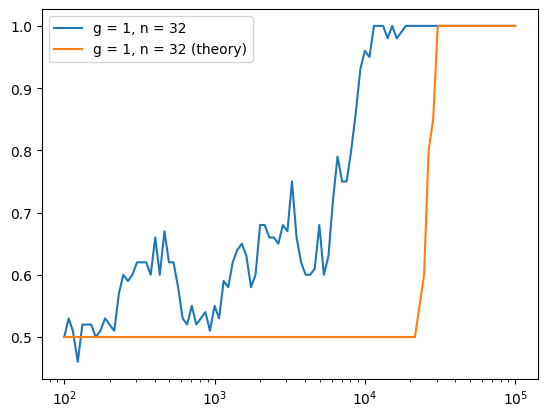

In [ ]:
from sklearn.metrics import roc_auc_score

def get_auc_for_vals(tvals, fvals):
    return roc_auc_score([1] * len(tvals) + [0] * len(fvals), tvals + fvals)

def eval_attack_auc(secret_dim, sample_dims, gamma,  beta, iters=100):
    max_sample_dim = max(sample_dims)
    secret_dir = sample_unit_vector(secret_dim, 42)
    norm_scores, clwe_scores = [], []
    for _ in range(iters):
        raw_samples = get_random_samples((max_sample_dim, secret_dim), var=1)
        clwe_samples = project_to_clwe(raw_samples, secret_dir, gamma, beta)
        norm_scores.append([ get_cov_score(raw_samples[:d]) for d in sample_dims ])
        clwe_scores.append([ get_cov_score(clwe_samples[:d]) for d in sample_dims ])
    
    # reformat to be by sample size first
    clwe_scores, norm_scores = tuple(zip(*clwe_scores)), tuple(zip(*norm_scores))

    return ([ get_auc_for_vals(clwe, norm) for clwe, norm in zip(clwe_scores, norm_scores) ],
            [ theory_accuracy(gamma, beta, clwe, norm) for clwe, norm in zip(clwe_scores, norm_scores) ])

gamma_vals = [1, 2, 4, 8]
n_vals = [32, 64]
m_vals = np.logspace(2, 6, num=100)
m_vals = np.unique(m_vals.astype(int))
all_results = []
all_tresults = []
for g in gamma_vals:
    n_results = []
    n_tresults = []
    for n in n_vals:
        results, t_results = eval_attack_auc(n, m_vals, g, 1e-3)
        plt.plot(m_vals, results, label=f"g = {g}, n = {n}")
        plt.plot(m_vals, t_results, label=f"g = {g}, n = {n} (theory)")
        plt.xscale('log')
        n_results.append(results)
        n_tresults.append(t_results)
    all_results.append(n_results)
    all_tresults.append(n_tresults)

plt.legend()


# write data to a CSV file
with open("cov_vs_samp.csv", 'wt') as f:
    print("gamma,n,m,auc,theory_acc", file=f)
    for g, g_results, g_tresults in zip(gamma_vals, all_results, all_tresults):
        for n, n_results, n_tresults in zip(n_vals, g_results, g_tresults):
            for m, r, t_acc in zip(m_vals, n_results, n_tresults):
                print(",".join([str(x) for x in [g, n, m, r, t_acc]]), file=f)
